# Code
***

# 1pm 07/05 - Different attempt

# Load
First, print the version of TensorFlow for clarity:

In [35]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [9]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Constants
student_id_seed = 432121 
dataset_dir = 'E:\\GUI\\hagridset' 
image_size = (64, 64)
batch_size = 16

# Load the full dataset
full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=student_id_seed,
    shuffle=True
)

# Save class names before applying any transformations
class_names = full_ds.class_names
num_classes = len(class_names)

# Determining the size of the dataset
total_batches = tf.data.experimental.cardinality(full_ds).numpy()

# Calculating split sizes for 70% training, 10% validation, 20% test
train_size = int(0.7 * total_batches)
test_size = int(0.2 * total_batches)
val_size = total_batches - train_size - test_size  # This should be 10%

# Splitting the datasets
train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
test_ds = remaining_ds.take(test_size)
val_ds = remaining_ds.skip(test_size)

# Caching and prefetching for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Outputting the number of batches in each dataset
print(f"Number of batches in training dataset: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of batches in validation dataset: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Number of batches in test dataset: {tf.data.experimental.cardinality(test_ds).numpy()}")


Found 125912 files belonging to 18 classes.
Number of batches in training dataset: 5509
Number of batches in validation dataset: 787
Number of batches in test dataset: 1574


# Define and train cnn 

Epoch 1/10
5509/5509 [==============================] - 73s 13ms/step - loss: 2.3587 - accuracy: 0.2404 - val_loss: 1.7317 - val_accuracy: 0.4590
Epoch 2/10
5509/5509 [==============================] - 81s 15ms/step - loss: 1.6417 - accuracy: 0.4671 - val_loss: 1.2526 - val_accuracy: 0.5987
Epoch 3/10
5509/5509 [==============================] - 69s 13ms/step - loss: 1.3030 - accuracy: 0.5758 - val_loss: 1.0330 - val_accuracy: 0.6655
Epoch 4/10
5509/5509 [==============================] - 70s 13ms/step - loss: 1.1340 - accuracy: 0.6292 - val_loss: 0.9132 - val_accuracy: 0.7046
Epoch 5/10
5509/5509 [==============================] - 68s 12ms/step - loss: 1.0222 - accuracy: 0.6630 - val_loss: 0.8437 - val_accuracy: 0.7267
Epoch 6/10
5509/5509 [==============================] - 68s 12ms/step - loss: 0.9493 - accuracy: 0.6864 - val_loss: 0.8446 - val_accuracy: 0.7266
Epoch 7/10
5509/5509 [==============================] - 69s 12ms/step - loss: 0.8929 - accuracy: 0.7045 - val_loss: 0.8052 -

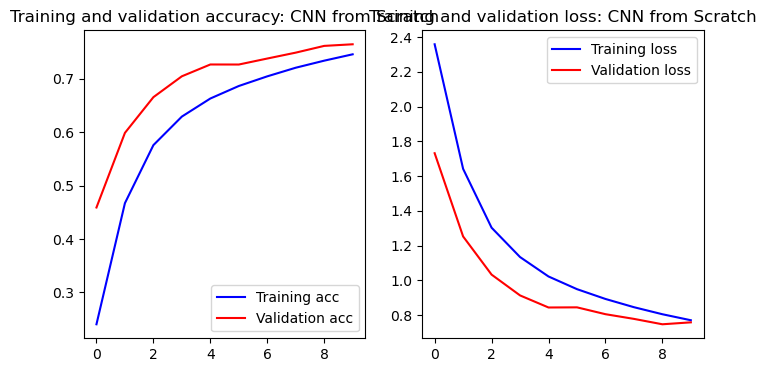

In [11]:
# Function to build a simple CNN model
def build_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the model (do not evaluate on the test set here)
input_shape = (64, 64, 3)
model_scratch = build_scratch_model(input_shape, num_classes)
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_scratch, "CNN from Scratch")


# Transfer learning

Epoch 1/10
5509/5509 [==============================] - 184s 33ms/step - loss: 4.8252 - accuracy: 0.0829 - val_loss: 4.2403 - val_accuracy: 0.1213
Epoch 2/10
5509/5509 [==============================] - 175s 32ms/step - loss: 3.5563 - accuracy: 0.2654 - val_loss: 2.5401 - val_accuracy: 0.4249
Epoch 3/10
5509/5509 [==============================] - 169s 31ms/step - loss: 1.7470 - accuracy: 0.6550 - val_loss: 1.2618 - val_accuracy: 0.7908
Epoch 4/10
5509/5509 [==============================] - 180s 33ms/step - loss: 1.1242 - accuracy: 0.8226 - val_loss: 1.0515 - val_accuracy: 0.8400
Epoch 5/10
5509/5509 [==============================] - 173s 31ms/step - loss: 0.9111 - accuracy: 0.8728 - val_loss: 0.9524 - val_accuracy: 0.8523
Epoch 6/10
5509/5509 [==============================] - 181s 33ms/step - loss: 0.7627 - accuracy: 0.9034 - val_loss: 0.9108 - val_accuracy: 0.8639
Epoch 7/10
5509/5509 [==============================] - 172s 31ms/step - loss: 0.6455 - accuracy: 0.9274 - val_loss: 0

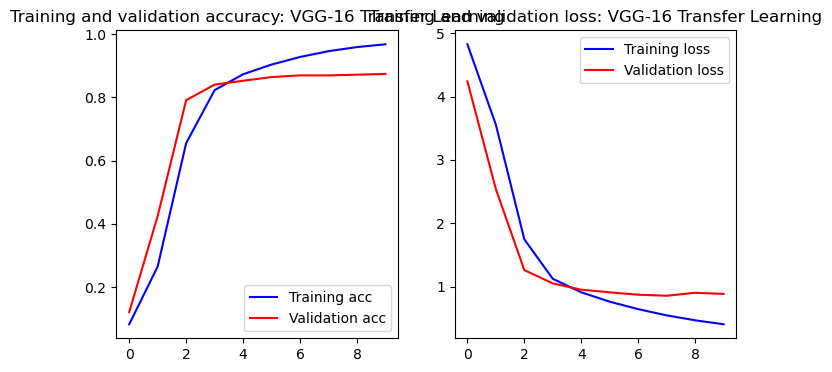

In [13]:
from tensorflow.keras.applications import VGG16

# Function to build the VGG-16 model with transfer learning and fine-tuning
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    # Unfreeze the last 8 layers for fine-tuning
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load dataset and class names
input_shape = (64, 64, 3)
num_classes = len(class_names)  

# Train the transfer model
model_transfer = build_transfer_model(input_shape, num_classes)
history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_transfer, "VGG-16 Transfer Learning")

# Model Iterations
***

## Greyscale CNN

First, we need to set the grayscale dataset

In [14]:
# Load the full grayscale dataset
full_ds_gray = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=student_id_seed,
    shuffle=True,
    color_mode='grayscale'
)

# Save class names specifically for grayscale
class_names_gray = full_ds_gray.class_names
num_classes_gray = len(class_names_gray)

# Calculate split sizes and split the grayscale datasets
total_batches_gray = tf.data.experimental.cardinality(full_ds_gray).numpy()
train_size_gray = int(0.7 * total_batches_gray)
test_size_gray = int(0.2 * total_batches_gray)
val_size_gray = total_batches_gray - train_size_gray - test_size_gray

train_ds_gray = full_ds_gray.take(train_size_gray)
remaining_ds_gray = full_ds_gray.skip(train_size_gray)
test_ds_gray = remaining_ds_gray.take(test_size_gray)
val_ds_gray = remaining_ds_gray.skip(test_size_gray)

# Cache and prefetch for performance improvement in grayscale datasets
train_ds_gray = train_ds_gray.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_gray = val_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_gray = test_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)

# Output the batch sizes for grayscale datasets
print(f"Grayscale Training batches: {tf.data.experimental.cardinality(train_ds_gray).numpy()}")
print(f"Grayscale Validation batches: {tf.data.experimental.cardinality(val_ds_gray).numpy()}")
print(f"Grayscale Test batches: {tf.data.experimental.cardinality(test_ds_gray).numpy()}")

Found 125912 files belonging to 18 classes.
Grayscale Training batches: 5509
Grayscale Validation batches: 787
Grayscale Test batches: 1574


In [15]:
# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

Epoch 1/10
5509/5509 [==============================] - 360s 61ms/step - loss: 2.4933 - accuracy: 0.1932 - val_loss: 1.9078 - val_accuracy: 0.3789
Epoch 2/10
5509/5509 [==============================] - 73s 13ms/step - loss: 1.8381 - accuracy: 0.4011 - val_loss: 1.5482 - val_accuracy: 0.5031
Epoch 3/10
5509/5509 [==============================] - 67s 12ms/step - loss: 1.5840 - accuracy: 0.4817 - val_loss: 1.3258 - val_accuracy: 0.5739
Epoch 4/10
5509/5509 [==============================] - 64s 12ms/step - loss: 1.4354 - accuracy: 0.5311 - val_loss: 1.2385 - val_accuracy: 0.5982
Epoch 5/10
5509/5509 [==============================] - 71s 13ms/step - loss: 1.3398 - accuracy: 0.5619 - val_loss: 1.1688 - val_accuracy: 0.6229
Epoch 6/10
5509/5509 [==============================] - 76s 14ms/step - loss: 1.2614 - accuracy: 0.5865 - val_loss: 1.1140 - val_accuracy: 0.6425
Epoch 7/10
5509/5509 [==============================] - 70s 13ms/step - loss: 1.2151 - accuracy: 0.5996 - val_loss: 1.0912 

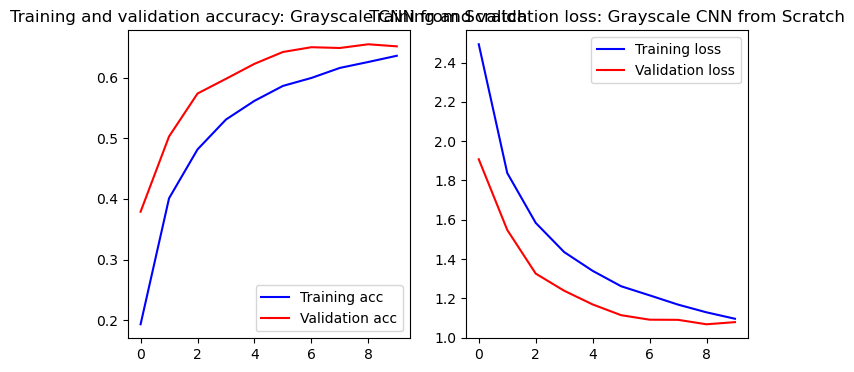

In [16]:
# Function to build a grayscale CNN model
def build_scratch_model_gray(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming train_ds_gray and val_ds_gray are defined and properly set up as grayscale datasets
input_shape_gray = (64, 64, 1)
model_scratch_gray = build_scratch_model_gray(input_shape_gray, num_classes)

# Train the grayscale scratch model
history_scratch_gray = model_scratch_gray.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=10,
    batch_size=batch_size
)

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history_scratch_gray, "Grayscale CNN from Scratch")

## Deeper CNN

Epoch 1/10
5509/5509 [==============================] - 580s 99ms/step - loss: 2.8544 - accuracy: 0.0987 - val_loss: 2.6057 - val_accuracy: 0.1820 - lr: 1.0000e-04
Epoch 2/10
5509/5509 [==============================] - 515s 94ms/step - loss: 2.4335 - accuracy: 0.2157 - val_loss: 1.9247 - val_accuracy: 0.3859 - lr: 1.0000e-04
Epoch 3/10
5509/5509 [==============================] - 552s 100ms/step - loss: 1.9333 - accuracy: 0.3734 - val_loss: 1.6797 - val_accuracy: 0.4577 - lr: 1.0000e-04
Epoch 4/10
5509/5509 [==============================] - 538s 98ms/step - loss: 1.5938 - accuracy: 0.4859 - val_loss: 1.3297 - val_accuracy: 0.5659 - lr: 1.0000e-04
Epoch 5/10
5509/5509 [==============================] - 538s 98ms/step - loss: 1.3717 - accuracy: 0.5596 - val_loss: 1.2153 - val_accuracy: 0.6165 - lr: 1.0000e-04
Epoch 6/10
5509/5509 [==============================] - 548s 100ms/step - loss: 1.2227 - accuracy: 0.6090 - val_loss: 0.9893 - val_accuracy: 0.6799 - lr: 1.0000e-04
Epoch 7/10
550

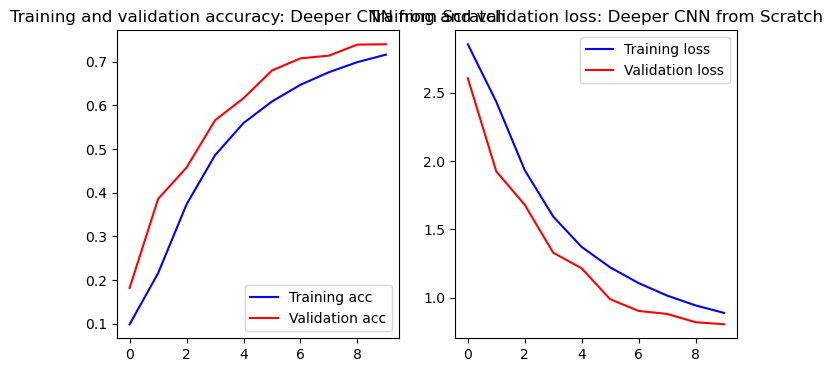

In [18]:
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages
logging.getLogger('tensorflow').setLevel(logging.ERROR) 

# Data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Function to build a deeper CNN model with data augmentation and normalization
def build_deeper_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping and ReduceLROnPlateau Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Train and evaluate the deeper scratch model
input_shape_deeper = (64, 64, 3)

model_deeper_scratch = build_deeper_scratch_model(input_shape_deeper, num_classes)
history_deeper_scratch = model_deeper_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot training history without involving test data
plot_history(history_deeper_scratch, "Deeper CNN from Scratch")


## Data Augmentation

CNN

In [19]:
import logging
import os
import tensorflow as tf

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

Epoch 1/10
5509/5509 [==============================] - 519s 93ms/step - loss: 2.8285 - accuracy: 0.0920 - val_loss: 2.7091 - val_accuracy: 0.1465 - lr: 0.0010
Epoch 2/10
5509/5509 [==============================] - 499s 91ms/step - loss: 2.6636 - accuracy: 0.1532 - val_loss: 2.4022 - val_accuracy: 0.2397 - lr: 0.0010
Epoch 3/10
5509/5509 [==============================] - 508s 92ms/step - loss: 2.3963 - accuracy: 0.2319 - val_loss: 2.0589 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 4/10
5509/5509 [==============================] - 514s 93ms/step - loss: 2.1664 - accuracy: 0.3030 - val_loss: 1.8682 - val_accuracy: 0.4072 - lr: 0.0010
Epoch 5/10
5509/5509 [==============================] - 512s 93ms/step - loss: 2.0373 - accuracy: 0.3443 - val_loss: 1.6954 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 6/10
5509/5509 [==============================] - 514s 93ms/step - loss: 1.9532 - accuracy: 0.3731 - val_loss: 1.6193 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 7/10
5509/5509 [==================

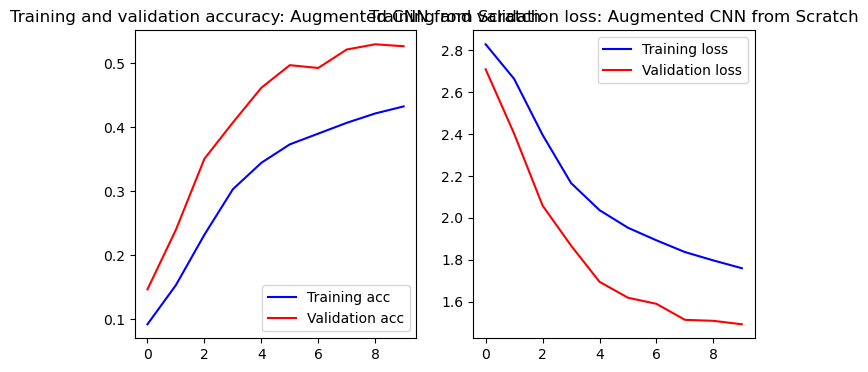

In [20]:
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Function to build a base CNN model with data augmentation
def build_augmented_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping and Reduce Learning Rate on Plateau Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Train and evaluate the augmented scratch model
input_shape_augmented = (64, 64, 3)
model_augmented_scratch = build_augmented_scratch_model(input_shape_augmented, num_classes)
history_augmented_scratch = model_augmented_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f"Training and validation accuracy: {title}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f"Training and validation loss: {title}")
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_augmented_scratch, "Augmented CNN from Scratch")


VGG

Epoch 1/10
5509/5509 [==============================] - 628s 113ms/step - loss: 3.6723 - accuracy: 0.2040 - val_loss: 2.2686 - val_accuracy: 0.5281 - lr: 1.0000e-05
Epoch 2/10
5509/5509 [==============================] - 617s 112ms/step - loss: 2.1662 - accuracy: 0.5475 - val_loss: 1.7545 - val_accuracy: 0.6602 - lr: 1.0000e-05
Epoch 3/10
5509/5509 [==============================] - 621s 113ms/step - loss: 1.7735 - accuracy: 0.6530 - val_loss: 1.5211 - val_accuracy: 0.7205 - lr: 1.0000e-05
Epoch 4/10
5509/5509 [==============================] - 620s 112ms/step - loss: 1.5671 - accuracy: 0.7038 - val_loss: 1.3599 - val_accuracy: 0.7576 - lr: 1.0000e-05
Epoch 5/10
5509/5509 [==============================] - 618s 112ms/step - loss: 1.4164 - accuracy: 0.7364 - val_loss: 1.2732 - val_accuracy: 0.7682 - lr: 1.0000e-05
Epoch 6/10
5509/5509 [==============================] - 618s 112ms/step - loss: 1.3007 - accuracy: 0.7602 - val_loss: 1.1759 - val_accuracy: 0.7873 - lr: 1.0000e-05
Epoch 7/10

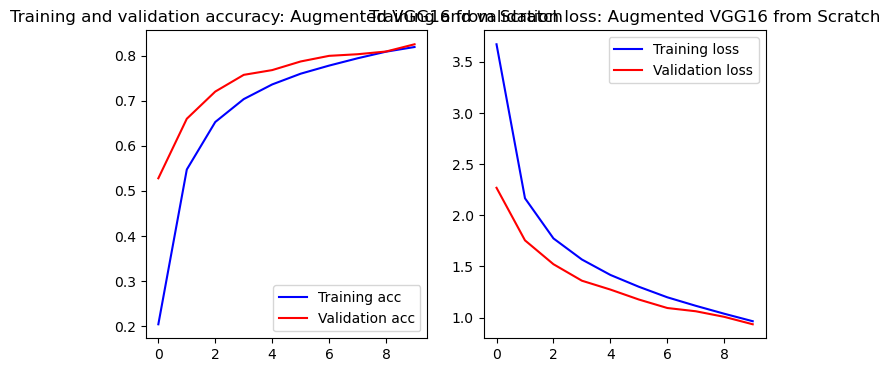

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Data augmentation layer
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Function to build a VGG16 transfer learning model with data augmentation
def build_augmented_vgg16_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model = models.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early Stopping and Reduce Learning Rate on Plateau Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

# Train and evaluate the augmented VGG16 model
input_shape_augmented = (64, 64, 3)
model_augmented_vgg16 = build_augmented_vgg16_model(input_shape_augmented, num_classes)
history_augmented_vgg16 = model_augmented_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f"Training and validation accuracy: {title}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f"Training and validation loss: {title}")
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_augmented_vgg16, "Augmented VGG16 from Scratch")


# Comparison and Testing

1574/1574 [==============================] - 20s 13ms/step - loss: 0.9443 - accuracy: 0.8165
Inference Time - Scratch Model (Color): 8.78s
Inference Time - Transfer Model (Color): 20.01s
Inference Time - Grayscale Scratch Model: 7.23s
Inference Time - Deeper Scratch Model: 11.43s
Inference Time - Augmented Scratch Model: 8.22s
Inference Time - Augmented VGG16 Model: 20.29s


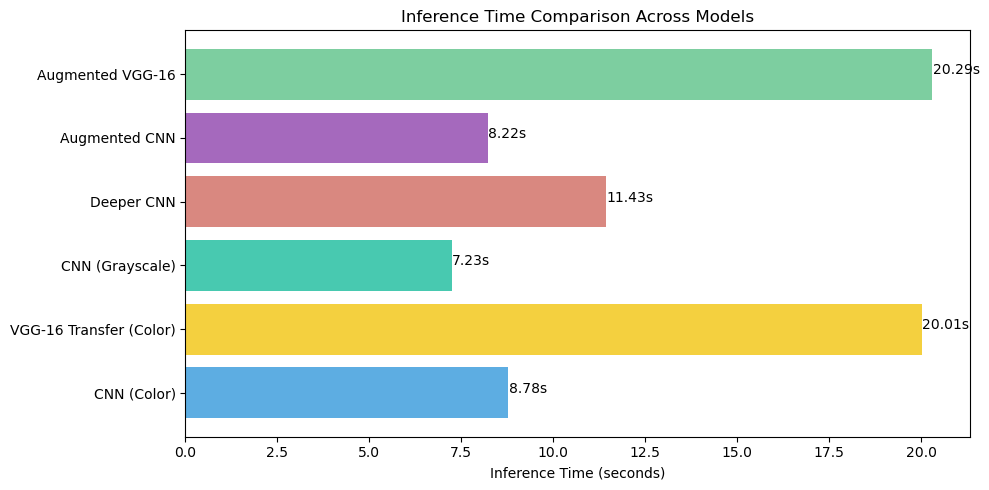

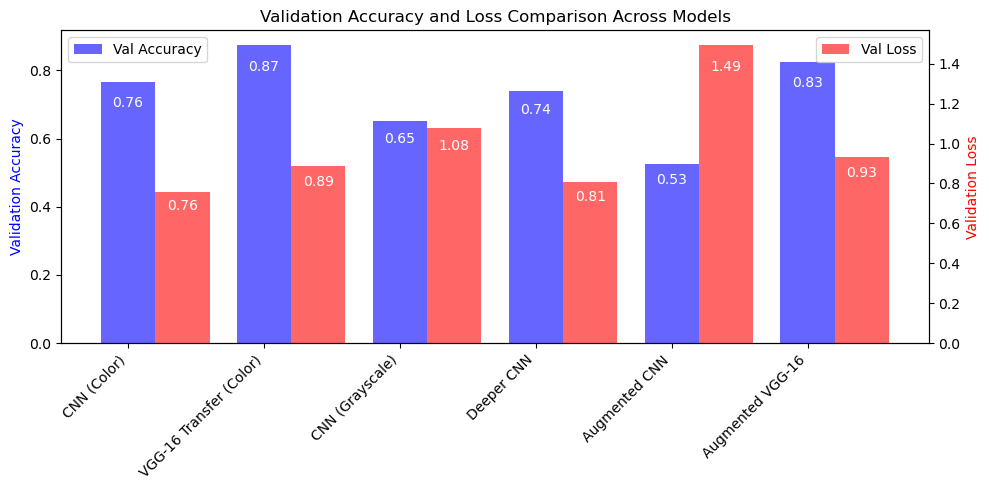

In [26]:
# Compare inference times
import time

def measure_inference_time(model, dataset):
    start_time = time.time()
    model.evaluate(dataset)
    elapsed_time = time.time() - start_time
    return elapsed_time

# Measure inference times
inference_time_scratch = measure_inference_time(model_scratch, test_ds)
inference_time_transfer = measure_inference_time(model_transfer, test_ds)
inference_time_scratch_gray = measure_inference_time(model_scratch_gray, test_ds_gray)
inference_time_deeper_scratch = measure_inference_time(model_deeper_scratch, test_ds)
inference_time_augmented_scratch = measure_inference_time(model_augmented_scratch, test_ds)
inference_time_augmented_vgg16 = measure_inference_time(model_augmented_vgg16, test_ds)

print(f"Inference Time - Scratch Model (Color): {inference_time_scratch:.2f}s")
print(f"Inference Time - Transfer Model (Color): {inference_time_transfer:.2f}s")
print(f"Inference Time - Grayscale Scratch Model: {inference_time_scratch_gray:.2f}s")
print(f"Inference Time - Deeper Scratch Model: {inference_time_deeper_scratch:.2f}s")
print(f"Inference Time - Augmented Scratch Model: {inference_time_augmented_scratch:.2f}s")
print(f"Inference Time - Augmented VGG16 Model: {inference_time_augmented_vgg16:.2f}s")

import matplotlib.pyplot as plt

# Model names and their corresponding inference times
model_names = [
    "CNN (Color)",
    "VGG-16 Transfer (Color)",
    "CNN (Grayscale)",
    "Deeper CNN",
    "Augmented CNN",
    "Augmented VGG-16"
]

inference_times = [
    inference_time_scratch,
    inference_time_transfer,
    inference_time_scratch_gray,
    inference_time_deeper_scratch,
    inference_time_augmented_scratch,
    inference_time_augmented_vgg16
]

# Validation accuracies and losses for plotting
val_accs = [
    history_scratch.history['val_accuracy'][-1],
    history_transfer.history['val_accuracy'][-1],
    history_scratch_gray.history['val_accuracy'][-1],
    history_deeper_scratch.history['val_accuracy'][-1],
    history_augmented_scratch.history['val_accuracy'][-1],
    history_augmented_vgg16.history['val_accuracy'][-1]
]

val_losses = [
    history_scratch.history['val_loss'][-1],
    history_transfer.history['val_loss'][-1],
    history_scratch_gray.history['val_loss'][-1],
    history_deeper_scratch.history['val_loss'][-1],
    history_augmented_scratch.history['val_loss'][-1],
    history_augmented_vgg16.history['val_loss'][-1]
]

# Create a comparative bar chart for inference time
plt.figure(figsize=(10, 5))
plt.barh(model_names, inference_times, color=['#5DADE2', '#F4D03F', '#48C9B0', '#D98880', '#A569BD', '#7DCEA0'])
plt.xlabel('Inference Time (seconds)')
plt.title('Inference Time Comparison Across Models')
for i, value in enumerate(inference_times):
    plt.text(value + 0.01, i, f"{value:.2f}s")
plt.tight_layout()
plt.show()

# Create a bar chart for validation accuracy and validation loss
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart for accuracies
width = 0.4  # the width of the bars
indices = range(len(model_names))  # the label locations
rects1 = ax1.bar(indices, val_accs, width, label='Val Accuracy', color='b', alpha=0.6)
ax1.set_ylabel('Validation Accuracy', color='b')
ax1.set_title('Validation Accuracy and Loss Comparison Across Models')
ax1.set_xticks(indices)
ax1.set_xticklabels(model_names, rotation=45, ha="right")
ax1.legend(loc='upper left')

# Adding text inside the accuracy bars
for rect, label in zip(rects1, val_accs):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height * 0.95, f'{label:.2f}', ha='center', va='top', color='white')

# Plot validation loss on the same graph
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
rects2 = ax2.bar([p + width for p in indices], val_losses, width, label='Val Loss', color='r', alpha=0.6)
ax2.set_ylabel('Validation Loss', color='r')
ax2.legend(loc='upper right')

# Adding text inside the loss bars
for rect, label in zip(rects2, val_losses):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height * 0.95, f'{label:.2f}', ha='center', va='top', color='white')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [10]:
# Final test using self-taken images
from tensorflow.keras.preprocessing import image

def predict_gesture(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class

gesture_images = ['images/image_like.jpg',
                  'images/image_ok.jpg',
                  'images/image_stop.jpg',
                  'images/image_two.jpg']

for img_path in gesture_images:
    predicted_gesture = predict_gesture(model_transfer, img_path, class_names)
    print(f"Prediction for {img_path}: {predicted_gesture}")


1/1 [==============================] - 0s 421ms/step
Prediction for images/image_like.jpg: like
1/1 [==============================] - 0s 22ms/step
Prediction for images/image_ok.jpg: ok
1/1 [==============================] - 0s 23ms/step
Prediction for images/image_stop.jpg: stop
1/1 [==============================] - 0s 25ms/step
Prediction for images/image_two.jpg: two_up
